In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import yfinance as yf

## Bulding the data base of the different cryptos

In [50]:
class DataBase:
    def __init__(self, kind):
        self.kind = kind
        self.data = {}
        if kind == 'crypto':
            self.add = self._add_crypto
        elif kind == 'stock':
            self.add = self._add_stock
        else:
            raise ValueError(f'Found no kind named: {kind}')
    
    def _add_crypto(self, name, color, symbol, amount, category, yf_add_ons='-USD'):
        if name not in self.data:
            try:
                self.data[name] = {
                    'color': color,
                    'symbol': symbol,
                    'current_price': yf.Ticker(f'{symbol}{yf_add_ons}').history(period='1d')['Open'][0],
                    'start_date': datetime.datetime.strptime(yf.Ticker(f'{symbol}{yf_add_ons}').info['startDate'], '%Y-%m-%d'),
                    'portfolio_amount': amount, 
                    'kind': 'crypto',
                    'category': category,
                    'symbol_add_on': yf_add_ons
                }
            except Exception as e:
                print(f'An {e} has occurred while extracting data for: {name}')
        else:
            print(f'{name} already in DataBase')
        
    def _add_stock(self, name, color, symbol, amount):
        if name not in self.data:
            try:
                self.data[name] = {
                    'color': color,
                    'symbol': symbol,
                    'current_price': yf.Ticker(symbol).history(period='1d')['Open'][0],
                    'start_date': datetime.datetime.strptime(yf.Ticker(symbol).info['startDate'], '%Y-%m-%d'),
                    'portfolio_amount': amount, 
                    'kind': 'stock'
                }
            except Exception as e:
                print(f'An {e} has occurred while extracting data for: {name}')
        else:
            print(f'{name} already in DataBase')
        
    def remove(self, name):
        if name in self.data:
            del self.data[name]
        else:
            print(f'{name} not found in DataBase')
    
    def get_info(self, name):
        return self.data.get(name, f'{name} not found in DataBase')
    
    def update_amount(self, name, amount):
        if name in self.data:
            self.data[name]['portfolio_amount'] = amount
        else:
            print(f'{name} not found in DataBase')
        
    def update_prices(self):
        if self.kind == 'crypto':
            for name, details in self.data.items():
                self.data[name] = yf.Ticker(details['symbol']+details['symbol_add_on']).history(period='1d')['Open'][0]
        elif self.kind =='stock':
            for name, details in self.data.items():
                self.data[name] = yf.Ticker(details['symbol']).history(period='1d')['Open'][0]
    
    def filter_by_category(self, categories):
        filterd = {}
        for name, details in self.data.items():
            if details['category'] in categories:
                filterd[name] = details
        return filterd 
    
    def calculate_distribution(self, total_investment, distribution):
        for category_name, category_info in distribution.items():
            category_total = total_investment * (category_info['precentage'] / 100)
            for asset_name, precentage in category_info['assets'].items():
                amount_in_currency = category_total * (precentage / 100)
                if asset_name in self.data:
                    self.data[asset_name]['portfolio_amount'] = amount_in_currency / self.data[asset_name]['current_price']
                else:
                    print(f"{asset} is not in the DataBase.")
    
    @staticmethod
    def create_distribution(*categories):
        distribution = {}
        for category in categories:
            name, precentage, *assets = category
            assets_distribution = {asset_name: asset_percentage for asset_name, asset_percentage in assets}
            distribution[name] = {'precentage': precentage, 'assets': assets_distribution}
        return distribution

### Adding data

In [51]:
# New empty crypto database
db = DataBase('crypto')

# Foundational Assets
db.add('Bitcoin', '#F7931A', 'BTC', 0, 'Foundational Assets')
db.add('Ethereum', '#627EEA', 'ETH', 0, 'Foundational Assets')

# Interoperability Protocols
db.add('Chainlink', '#0040DE', 'LINK', 0, 'Interoperability Protocols')
db.add('Cosmos', '#003A5E', 'ATOM', 0, 'Interoperability Protocols')
# db.add('Polkadot', '#FF00FF', 'DOT', 0, 'Interoperability Protocols')

# Ethereum Killers
db.add('Cardano', '#000000', 'ADA', 0, 'Ethereum Killers')
db.add('Solana', '#00D1B7', 'SOL', 0, 'Ethereum Killers')
# db.add('Avalanche', '#FF1C1B', 'AVAX', 0, 'Ethereum Killers')
# db.add('Algorand', '#000000', 'ALGO', 0, 'Ethereum Killers')

# Ethereum Scaling Solutions
db.add('Polygon', '#AA02EA', 'MATIC', 0, 'Ethereum Scaling Solutions')
db.add('Arbitrum', '#00ACFF', 'ARB', 0, 'Ethereum Scaling Solutions', yf_add_ons='11841-USD')
# db.add('Loopring', '#00B6FF', 'LRC', 0, 'Ethereum Scaling Solutions')
# db.add('Hermez Network', '#FF5D00', 'HEZ', 0, 'Ethereum Scaling Solutions')

# Top DeFi Protocols
db.add('Uniswap', '#FC007A', 'UNI', 0, 'DeFi Protocols', yf_add_ons='7083-USD')
db.add('Aave', '#749390', 'AAVE', 0, 'DeFi Protocols')
# db.add('Maker DAO', '#00DAA0', 'MKR', 0, 'DeFi Protocols')
# db.add('Lido DAO', '#FFB5AD', 'LDO', 0, 'DeFi Protocols')
# db.add('Compound', '#00002C', 'COMP', 0, 'DeFi Protocols', yf_add_ons='5692-USD')

In [52]:
assets_dict = db.data

# Listing all the different categories in the assets_dict
categories = list(pd.DataFrame(assets_dict).T['category'].unique())

In [53]:
start_date_string = pd.DataFrame(assets_dict).T['start_date'].max().date().strftime('%Y-%m-%d')
start_date = datetime.datetime.strptime(start_date_string, '%Y-%m-%d').date()

## Pulling price data

In [54]:
# Making the price history DataFrame
my_assets = [asset for asset in assets_dict]
price_history = pd.DataFrame()

for asset in my_assets:
    
    ticker = assets_dict[asset]['symbol']+assets_dict[asset]['symbol_add_on']
    
    try:
        Open = yf.Ticker(ticker).history(start=start_date_string)['Open']
        
    except Exception as e:
                print(f'An {e} has occurred while extracting data for: {asset}')
            
    Open.index = pd.DatetimeIndex(Open.index.date)
    
    price_history[asset] = Open

price_history.fillna(method='ffill', inplace=True)
price_history.fillna(method='backfill', inplace=True)

In [55]:
price_history.tail()

,Bitcoin,Ethereum,Chainlink,Cosmos,Cardano,Solana,Polygon,Arbitrum,Uniswap,Aave
2023-07-02,30587.269531,1924.448120,6.497801,9.562598,0.292352,18.689669,0.676716,1.150222,5.582826,68.142067
2023-07-03,30624.515625,1937.883789,6.530455,9.588395,0.292042,19.452414,0.681519,1.150747,5.568242,70.691757
2023-07-04,31156.865234,1955.524170,6.620317,9.933070,0.296334,19.242031,0.713739,1.166853,5.525380,72.887596
2023-07-05,30778.724609,1936.796753,6.526517,9.689937,0.292620,19.145613,0.696120,1.149537,5.510730,77.072128
2023-07-06,30484.326172,1909.514038,6.295680,9.379926,0.283796,19.006844,0.669624,1.111195,5.407556,74.657799


In [56]:
# Different types of returns
def arithmetic_returns(price):
    return (price/price.shift(1)) - 1

def logarithmic_returns(price):
    return np.log(price/price.shift(1))

# making the return history DataFrame
return_history = pd.DataFrame(columns=[f'{asset} return' for asset in price_history.columns])

for asset in price_history.columns:
    return_history[f'{asset} return'] = logarithmic_returns(price_history[asset]).dropna()
return_history.index = pd.DatetimeIndex(return_history.index.date)

In [57]:
return_history.tail()

,Bitcoin return,Ethereum return,Chainlink return,Cosmos return,Cardano return,Solana return,Polygon return,Arbitrum return,Uniswap return,Aave return
2023-07-02,0.003781,-0.004601,0.029554,0.029083,0.018626,-0.010983,0.023480,-0.008893,0.056275,-0.032970
2023-07-03,0.001217,0.006957,0.005013,0.002694,-0.001061,0.040000,0.007072,0.000456,-0.002616,0.036734
2023-07-04,0.017234,0.009062,0.013667,0.035316,0.014590,-0.010874,0.046193,0.013899,-0.007727,0.030589
2023-07-05,-0.012211,-0.009623,-0.014270,-0.024782,-0.012612,-0.005023,-0.024995,-0.014951,-0.002655,0.055823
2023-07-06,-0.009611,-0.014187,-0.036010,-0.032516,-0.030621,-0.007274,-0.038806,-0.033923,-0.018900,-0.031827


## Combining price data into indexes by category

In [58]:
# Listing all the different categories in the assets_dict
categories = list(pd.DataFrame(assets_dict).T['category'].unique())

# Getting the crypto project per category
category_mapping = {category: [asset for asset in my_assets if assets_dict[asset]['category'] == category] for category in categories}

In [59]:
category_index_returns = pd.DataFrame()
for category in category_mapping:
    
    assets_in_category = category_mapping[category]
    
    # Calculating the mean return of all projects in the category
    mean_return = return_history[[f'{asset} return' for asset in assets_in_category]].mean(axis=1)
    category_index_returns[f'{category} return'] = mean_return

In [60]:
category_index_returns.tail()

,Foundational Assets return,Interoperability Protocols return,Ethereum Killers return,Ethereum Scaling Solutions return,DeFi Protocols return
2023-07-02,-0.000410,0.029319,0.003822,0.007294,0.011652
2023-07-03,0.004087,0.003853,0.019470,0.003764,0.017059
2023-07-04,0.013148,0.024491,0.001858,0.030046,0.011431
2023-07-05,-0.010917,-0.019526,-0.008818,-0.019973,0.026584
2023-07-06,-0.011899,-0.034263,-0.018948,-0.036364,-0.025363


## Creating an index to track the top 30 crypto currencies

In [61]:
import requests

number_of_coins = 30

# Make an HTTP request to a cryptocurrency market data API to get the top cryptocurrencies by market cap.
url = f'https://api.coinmarketcap.com/data-api/v3/cryptocurrency/listing?start=1&limit={number_of_coins}&sortBy=market_cap&sortType=desc'
response = requests.get(url)
data = response.json()

# Parse the response to extract the symbols and market caps of the cryptocurrencies exculding stablecoins.
cryptos = {coin['symbol']: coin['quotes'][0]['marketCap'] for coin in data['data']['cryptoCurrencyList'] if 'stablecoin' not in coin['tags'] and datetime.datetime.strptime(coin['dateAdded'], '%Y-%m-%dT%H:%M:%S.%fZ').date() <= start_date}

In [62]:
# Create a list of ticker symbols with '-USD' appended.
tickers = [f'{symbol}-USD' for symbol, _ in cryptos.items()] 

# Use yfinance's yf.Tickers() with the list of ticker symbols to download the historical price data for each cryptocurrency.
index_price_history = yf.Tickers(tickers).history(start=start_date)['Open']
index_price_history.fillna(method='ffill', inplace=True)
index_price_history.fillna(method='backfill', inplace=True)

today = datetime.date.today()
expected_length = (today - start_date).days - (today - start_date).days * 0.01
for asset, datapoints in dict(index_price_history.nunique()).items():
    if datapoints < expected_length:
        del cryptos[asset.split('-')[0]]
        index_price_history.drop(asset, axis=1, inplace=True)
        

[*********************100%***********************]  25 of 25 completed


In [63]:
# Calculate the daily percentage change in prices for each cryptocurrency.
index_return_history = logarithmic_returns(index_price_history).dropna()

In [64]:
# Calculate the total market cap of all cryptocurrencies.
total_market_cap = sum([market_cap for _, market_cap in cryptos.items()])

# Calculate the weight of each cryptocurrency by dividing its market cap by the total market cap.
weights = {symbol: market_cap/total_market_cap for symbol, market_cap in cryptos.items()}

# Multiply the daily returns by the corresponding weights.
weighted_returns = index_return_history.multiply(list(weights.values()))

# Sum the weighted returns for each day to get the daily returns of the index
market_returns = weighted_returns.sum(axis=1)

In [65]:
market_returns.tail()

Date
2023-07-02    0.018281
2023-07-03    0.000788
2023-07-04    0.017711
2023-07-05   -0.016783
2023-07-06   -0.028959
dtype: float64

## Optimizing and comparing results

In [66]:
class PortfolioOptimizer:
    
    def __init__(self ,assets_returns, market_returns, num_ports=5000):
        self.assets_returns = assets_returns
        self.market_returns = market_returns
        self.num_ports = num_ports
        self.portfolios = {}
        
    def _generate_weights(self):
        return np.random.dirichlet(np.ones(self.assets_returns.shape[1]), size=self.num_ports)
    
    def _calculate_preformance(self, weights):
        means = (self.assets_returns.mean() * 252).values
        cov_matrix = self.assets_returns.cov() * 252
        ret = np.sum(means * weights, axis=1)
        vol = [np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) for w in weights]
        return ret, vol
        
    def _calculate_sharpe_ratio(self, ret, vol):
        return ret/vol
    
    def _calculate_beta(self, weights):
        covariance_with_market = np.array([np.cov(self.assets_returns[asset], self.market_returns, ddof=1)[0, 1] for asset in self.assets_returns])
        market_variance = np.var(self.market_returns, ddof=1)
        betas_per_asset = covariance_with_market / market_variance
        return weights @ betas_per_asset
    
    def optimize(self):
        weights = self._generate_weights()
        ret, vol = self._calculate_preformance(weights)
        sharpe_ratio = self._calculate_sharpe_ratio(ret, vol)
        beta = self._calculate_beta(weights)
        
        self.portfolios['weights'] = weights
        self.portfolios['return'] = ret
        self.portfolios['volatility'] = vol
        self.portfolios['sharpe_ratio'] = sharpe_ratio
        self.portfolios['beta'] = beta

In [67]:
# optimization per category 
category_optimizer = PortfolioOptimizer(category_index_returns, market_returns, num_ports=100_000)
category_optimizer.optimize()

category_weights, category_ret, category_vol, category_sharpe_ratios, category_beta = [category_optimizer.portfolios[metric] for metric in category_optimizer.portfolios.keys()]
category_max = category_sharpe_ratios.argmax()
category_distrebution = {category: weight for category, weight in zip(categories, category_weights[category_max, :])}

In [68]:
# optimization per token
token_optimizer = PortfolioOptimizer(return_history, market_returns, num_ports=100_000)
token_optimizer.optimize()

token_weights, token_ret, token_vol, token_sharpe_ratios, token_beta = [token_optimizer.portfolios[metric] for metric in token_optimizer.portfolios.keys()]
token_max = token_sharpe_ratios.argmax()
token_distrebution = {asset: weight for asset, weight in zip(my_assets, token_weights[token_max, :])}

## Plotting results

In [21]:
def plot_portfolio(ax, weights, assets_pct_change):
    
    # Calculate the preformance
    port_ret = np.sum((assets_pct_change.mean(axis=0) * weights) * 252)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(assets_pct_change.cov()*252,weights)))
    port_sharpe_ratio = port_ret/port_vol
    
    ax.scatter(port_vol, port_ret, c='gray', ec='black', s=75, label='my portfolio', zorder=4)
    return port_sharpe_ratio

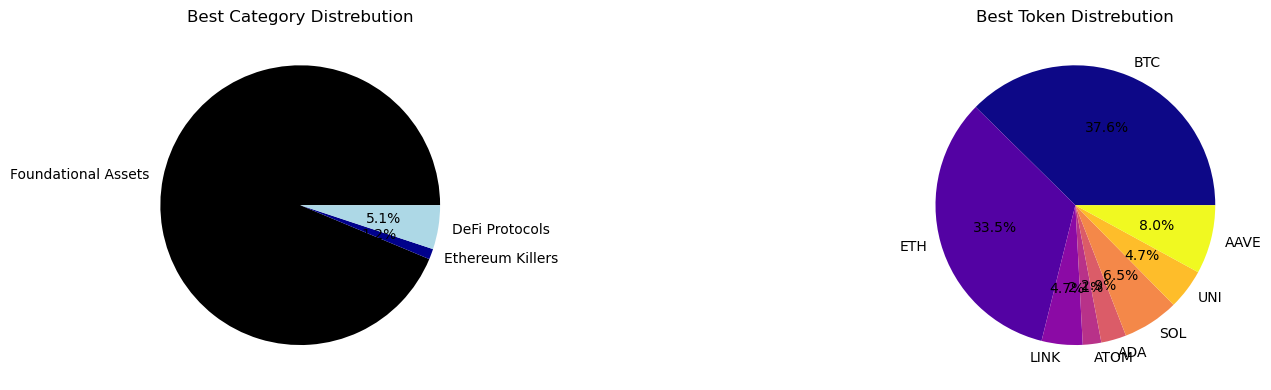

In [22]:
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ["black", "darkblue", "lightblue"])

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 4))
flattend_axes = axes.ravel()

category_distrebution_sizes = [amount for amount in category_distrebution.values() if amount >= 0.01]
category_distrebution_labels = [category for category in category_distrebution.keys() if category_distrebution[category] >= 0.01]
category_distrebution_colors = cmap(np.linspace(0, 1, len(category_distrebution_sizes)))

flattend_axes[0].pie(category_distrebution_sizes, labels=category_distrebution_labels, colors=category_distrebution_colors, autopct='%1.1f%%')
flattend_axes[0].set_title('Best Category Distrebution')

token_distrebution_sizes = [amount for amount in token_distrebution.values() if amount >= 0.01]
token_distrebution_labels = [assets_dict[token]['symbol'] for token in token_distrebution.keys() if token_distrebution[token] >= 0.01]
token_distrebution_colors = plt.cm.plasma(np.linspace(0, 1, len(token_distrebution_sizes)))

flattend_axes[1].pie(token_distrebution_sizes, labels=token_distrebution_labels, colors=token_distrebution_colors, autopct='%1.1f%%')
flattend_axes[1].set_title('Best Token Distrebution')
plt.tight_layout()

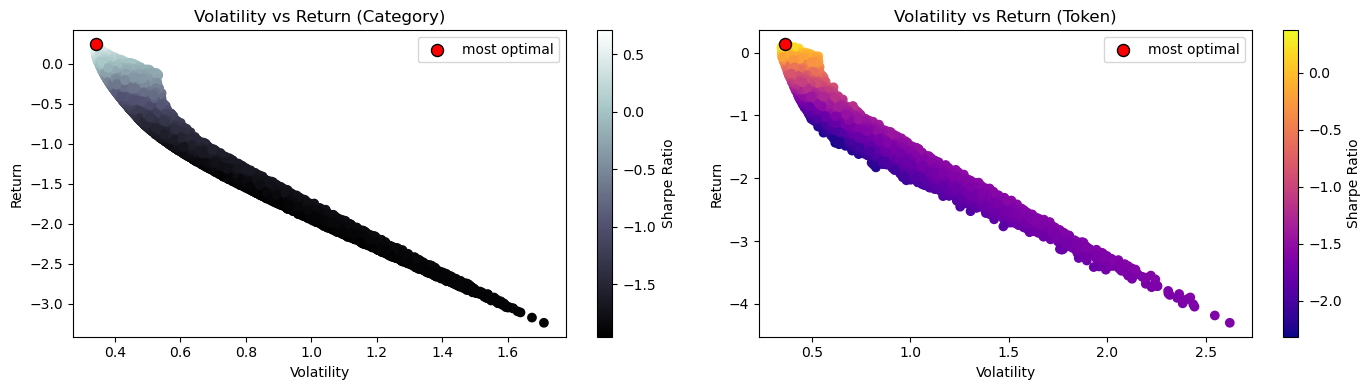

In [23]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))
flattend_axes = axes.ravel()

# Volatility vs Return (Category)
scatter0 = flattend_axes[0].scatter(category_vol, category_ret, c=category_sharpe_ratios, cmap='bone')
flattend_axes[0].scatter(category_vol[category_max], category_ret[category_max], c='red', ec='black', s=75, label='most optimal', zorder=4)
flattend_axes[0].set_ylabel('Return')
flattend_axes[0].set_xlabel('Volatility')
flattend_axes[0].set_title('Volatility vs Return (Category)')
fig.colorbar(scatter0, ax=flattend_axes[0], label='Sharpe Ratio')
flattend_axes[0].legend()


# Volatility vs Return (Token)
scatter1 = flattend_axes[1].scatter(token_vol, token_ret, c=token_sharpe_ratios, cmap='plasma')
flattend_axes[1].scatter(token_vol[token_max], token_ret[token_max], c='red', ec='black', s=75, label='most optimal', zorder=4)
flattend_axes[1].set_ylabel('Return')
flattend_axes[1].set_xlabel('Volatility')
flattend_axes[1].set_title('Volatility vs Return (Token)')
fig.colorbar(scatter1, ax=flattend_axes[1], label='Sharpe Ratio')
flattend_axes[1].legend()

plt.tight_layout()

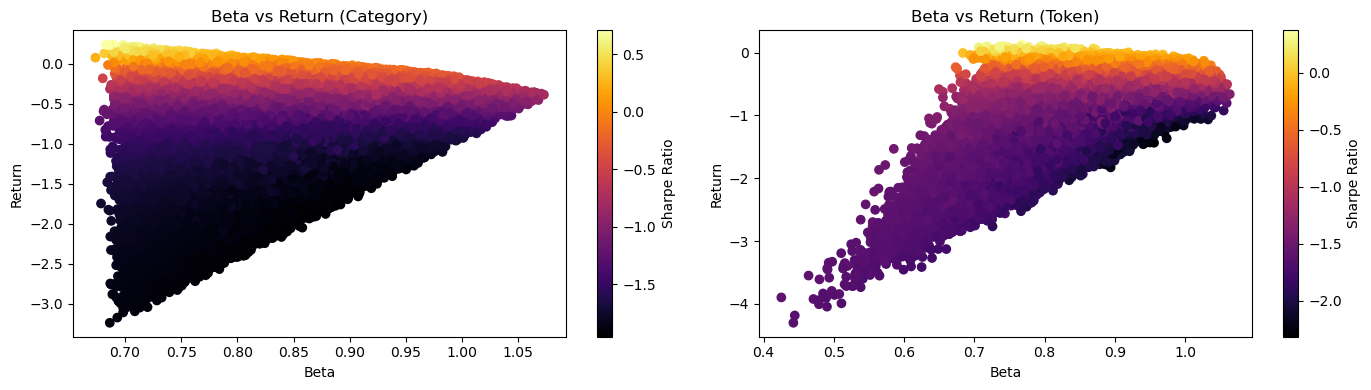

In [24]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))

# Beta vs. Return (Categories)
scatter2 = axes[0].scatter(category_beta, category_ret, c=category_sharpe_ratios, cmap='inferno')
axes[0].set_xlabel('Beta')
axes[0].set_ylabel('Return')
axes[0].set_title('Beta vs Return (Category)')
fig.colorbar(scatter2, ax=axes[0], label='Sharpe Ratio')

# Beta vs. Return (Tokens)
scatter3 = axes[1].scatter(token_beta, token_ret, c=token_sharpe_ratios, cmap='inferno')
axes[1].set_xlabel('Beta')
axes[1].set_ylabel('Return')
axes[1].set_title('Beta vs Return (Token)')
fig.colorbar(scatter3, ax=axes[1], label='Sharpe Ratio')

plt.tight_layout()

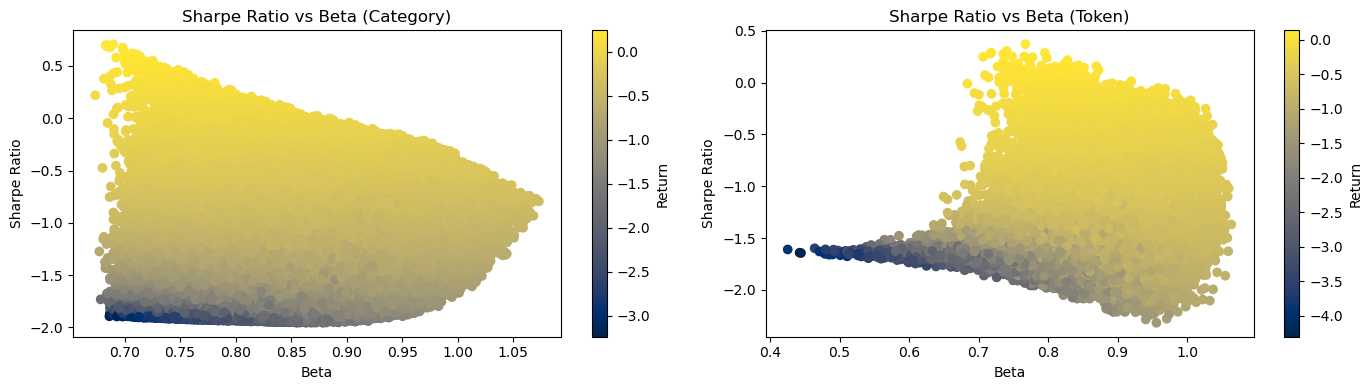

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))

# Sharpe Ratio vs. Beta (Categories)
scatter4 = axes[0].scatter(category_beta, category_sharpe_ratios, c=category_ret, cmap='cividis')
axes[0].set_xlabel('Beta')
axes[0].set_ylabel('Sharpe Ratio')
axes[0].set_title('Sharpe Ratio vs Beta (Category)')
fig.colorbar(scatter4, ax=axes[0], label='Return')

# Sharpe Ratio vs. Beta (Tokens)
scatter5 = axes[1].scatter(token_beta, token_sharpe_ratios, c=token_ret, cmap='cividis')
axes[1].set_xlabel('Beta')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_title('Sharpe Ratio vs Beta (Token)')
fig.colorbar(scatter5, ax=axes[1], label='Return')

plt.tight_layout()

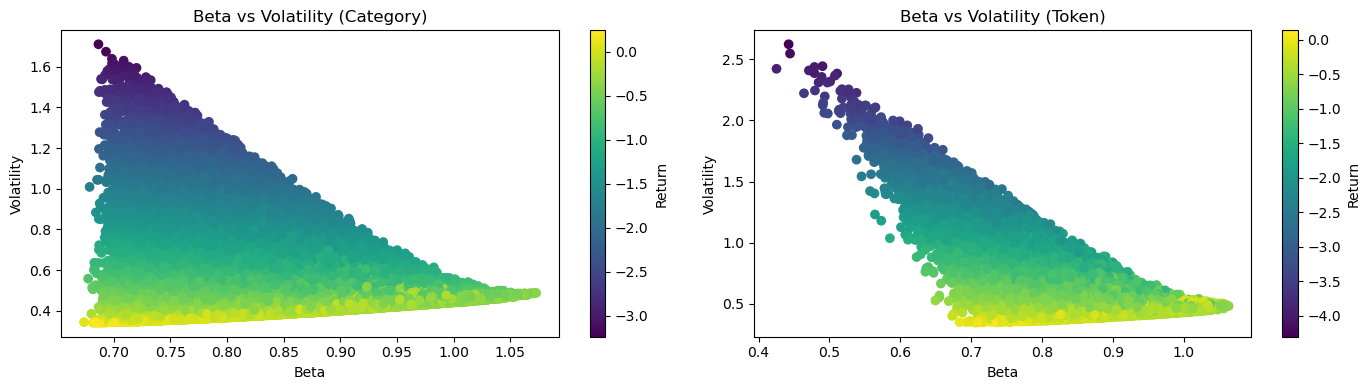

In [26]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))

# Beta vs. Volatility (Categories)
scatter6 = axes[0].scatter(category_beta, category_vol, c=category_ret, cmap='viridis')
axes[0].set_xlabel('Beta')
axes[0].set_ylabel('Volatility')
axes[0].set_title('Beta vs Volatility (Category)')
fig.colorbar(scatter6, ax=axes[0], label='Return')

# Beta vs. Volatility (Tokens)
scatter7 = axes[1].scatter(token_beta, token_vol, c=token_ret, cmap='viridis')
axes[1].set_xlabel('Beta')
axes[1].set_ylabel('Volatility')
axes[1].set_title('Beta vs Volatility (Token)')
fig.colorbar(scatter7, ax=axes[1], label='Return')

plt.tight_layout()

## Creating and calculating the investment distribution

In [69]:
from forex_python.converter import CurrencyRates

def currency_convertor(from_cur, to_cur, date):
    try:
        c = CurrencyRates()
        return_currency = c.get_rate(base_cur=from_cur, dest_cur=to_cur, date_obj=date)
        return return_currency
    except Exception:
        fallback_date = date - datetime.timedelta(days=1)
        return currency_convertor(from_cur, to_cur, fallback_date)

### for investing
- invested 18.6k
- for gas fees: 400 ₪

In [70]:
today = datetime.date.today()
my_ils_amount = (19_000 + 7131.38)
ils_rates = currency_convertor('ILS', 'USD', today)
my_usd_amount = my_ils_amount * ils_rates

In [71]:
distribution = DataBase.create_distribution(
    ('Foundational Assets', 70, ('Bitcoin', 62), ('Ethereum', 38)),
    ('Ethereum Scaling Solutions', 10, ('Polygon', 60), ('Arbitrum', 40)),
    ('DeFi Protocols', 5, ('Uniswap', 50), ('Aave', 50)),
    ('Ethereum Killers', 5, ('Cardano', 50), ('Solana', 50)),
    ('Interoperability Protocols', 10, ('Chainlink', 80), ('Cosmos', 20)))

In [72]:
db.calculate_distribution(my_usd_amount, distribution)

In [76]:
distribution_dict = {'USD Amount': [], 'Coin Amount': []}
asset_names = []
for asset, data in db.data.items():
    if data['portfolio_amount'] != 0:
        asset_names.append(asset)
        distribution_dict['Coin Amount'].append(data['portfolio_amount'])
        distribution_dict['USD Amount'].append(data['portfolio_amount'] * data['current_price'])

final_distribution = pd.DataFrame(distribution_dict, index=asset_names)

In [79]:
final_distribution

,USD Amount,Coin Amount
Bitcoin,3116.481679,0.102232
Ethereum,1910.101674,1.000308
Chainlink,574.466669,91.247762
Cosmos,143.616667,15.311067
Cardano,179.520834,632.571096
Solana,179.520834,9.445063
Polygon,430.850002,643.420644
Arbitrum,287.233334,258.490437
Uniswap,179.520834,33.198149
Aave,179.520834,2.404582


## Saving the final distribution

In [80]:
from pathlib import Path
file_path = Path.home() / 'Desktop/Programming/Python/csv-files/Investments-Distribution.csv'
final_distribution.to_csv(file_path)